# **End-to-End Reinforcement Learning with Human Feedback: Reward Modeling and PPO Training**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## **Load Libraries and configuration of the models**


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, pipeline
from trl import (
    AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer,
    RewardConfig, RewardTrainer, setup_chat_format, ModelConfig
)
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
import numpy as np

In [5]:
# Set model name and device (use GPU if available)
model_name = "gpt2"  # Base model name
# Use CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model configuration
model_config = ModelConfig(model_name_or_path=model_name)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_config.model_name_or_path,
    trust_remote_code=model_config.trust_remote_code,
    use_fast=True
)
# Ensure EOS token is used for padding
tokenizer.pad_token = tokenizer.eos_token

# Load models for different purposes: Classification, Reward, Value, Policy
model = AutoModelForSequenceClassification.from_pretrained(
    model_config.model_name_or_path, num_labels=1, trust_remote_code=model_config.trust_remote_code
)
# Reward model for reinforcement learning
reward_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)
# Value model for estimating state values
value_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)
# Policy model for generating actions
policy_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
# Reference policy model for comparison
ref_policy_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

## **Data Preparation**

In [6]:
# Load the ultrafeedback_binarized dataset from the Hugging Face Hub
dataset = load_dataset("trl-lib/ultrafeedback_binarized")

# Define a function to tokenize and preprocess the dataset
def tokenize_function(examples):
    """
    Tokenizes and preprocesses the input examples.

    Args:
        examples: A dictionary of examples containing the "chosen" key.

    Returns:
        A dictionary containing the tokenized input IDs, attention mask, etc.
    """
    return tokenizer(
        [str(x) for x in examples["chosen"]],
        truncation=True,  # Truncate sequences longer than max_length
        padding="max_length",  # Pad shorter sequences to max_length
        max_length=min(tokenizer.model_max_length, 200),  # Set max sequence length (reduced for CUDA memory)
        return_tensors="pt"  # Return PyTorch tensors
    )

# Apply the tokenize_function to the dataset using the `map` function
tokenized_dataset = dataset.map(
    tokenize_function,  # The function to apply
    batched=True,  # Process examples in batches for efficiency
    num_proc=4,  # Use 4 processes for parallel processing
)

In [ ]:
print(dataset) # Shows the features of the original dataset

DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected', 'score_chosen', 'score_rejected'],
        num_rows: 62135
    })
    test: Dataset({
        features: ['chosen', 'rejected', 'score_chosen', 'score_rejected'],
        num_rows: 1000
    })
})


In [ ]:
print(tokenized_dataset)  # Shows the features of the tokenized dataset

DatasetDict({
    train: Dataset({
        features: ['chosen', 'rejected', 'score_chosen', 'score_rejected', 'input_ids', 'attention_mask'],
        num_rows: 62135
    })
    test: Dataset({
        features: ['chosen', 'rejected', 'score_chosen', 'score_rejected', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})


In [ ]:
# Save the tokenizer
tokenizer.save_pretrained("drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer")

('drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer/tokenizer_config.json',
 'drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer/special_tokens_map.json',
 'drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer/vocab.json',
 'drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer/merges.txt',
 'drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer/added_tokens.json',
 'drive/MyDrive/M2 D3S/Math of DL/Project/tokenizer/tokenizer.json')

## **Train the Reward Model**

In [ ]:
# Set up chat format for the tokenizer and model if it's not already configured
if tokenizer.chat_template is None:
    # This ensures the tokenizer and model are compatible for chat-style interactions
    model, tokenizer = setup_chat_format(model, tokenizer)

# Configure training arguments for the reward model using RewardConfig
reward_config = RewardConfig(
    output_dir="drive/MyDrive/M2 D3S/Math of DL/Project",
    per_device_train_batch_size=8,
    num_train_epochs=1,
    logging_steps=25,  # Log training progress every 25 steps
    eval_strategy="steps",  # Evaluation strategy: evaluate every 'eval_steps'
    eval_steps=50,  # Evaluate every 50 steps
    remove_unused_columns=False,
    dataset_num_proc=4,
    report_to="none"  # Disable reporting to external tracking services
)

# Define a function to evaluate the model after the training
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Initialize the RewardTrainer with the configuration, model, tokenizer, and datasets
trainer = RewardTrainer(
    args=reward_config,  # Training arguments
    model=model,  # The model to train
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

# Start training the reward model
print("Training the reward model...")
trainer.train()
metrics = trainer.evaluate()

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
<ipython-input-5-d48eab8e7e16>:20: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.15.0 for `RewardTrainer.__init__`. Use `processing_class` instead.
  trainer = RewardTrainer(


Map:   0%|          | 0/62135 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/62135 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1942 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1096 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2164 > 1024). Running this sequence through the model will result in indexing errors


Filter (num_proc=4):   0%|          | 0/62135 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1366 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2495 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1100 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1187 > 1024). Running this sequence through the model will result in indexing errors


Filter (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Training the reward model...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5373, 0.4627] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 220 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5656, 0.4344] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 230 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5016, 0.4984] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 236 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4655, 0.5345] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 246 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5982, 0.4018] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 247 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4881, 0.5119] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 269 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4733, 0.5267] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 257 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.6038, 0.3962] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 261 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5437, 0.4563] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 276 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5427, 0.4573] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 254 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4302, 0.5698] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 280 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4585, 0.5415] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 261 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4859, 0.5141] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 274 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4553, 0.5447] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 272 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4942, 0.5058] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 237 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5379, 0.4621] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 261 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4874, 0.5126] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 274 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.542, 0.458]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 288 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4842, 0.5158] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 292 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4837, 0.5163] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 299 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5095, 0.4905] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 315 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4975, 0.5025] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 302 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5405, 0.4595] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 308 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5911, 0.4089] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 259 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4914, 0.5086] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 301 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4873, 0.5127] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 310 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.528, 0.472]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 325 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5328, 0.4672] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 326 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5664, 0.4336] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 301 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5012, 0.4988] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 261 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5121, 0.4879] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 297 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4686, 0.5314] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 320 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4889, 0.5111] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 286 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4425, 0.5575] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 308 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5534, 0.4466] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 296 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4954, 0.5046] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 288 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4888, 0.5112] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 300 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4812, 0.5188] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 295 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4916, 0.5084] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 291 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5159, 0.4841] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 312 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5246, 0.4754] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 322 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4985, 0.5015] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 324 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4771, 0.5229] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 312 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5108, 0.4892] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 333 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5432, 0.4568] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 323 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5021, 0.4979] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 333 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4861, 0.5139] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 335 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4813, 0.5187] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 352 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5106, 0.4894] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 334 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4733, 0.5267] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 338 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5343, 0.4657] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 323 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5086, 0.4914] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 338 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4942, 0.5058] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 356 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4744, 0.5256] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 340 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.413, 0.587]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 334 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4574, 0.5426] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 348 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4924, 0.5076] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 347 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4939, 0.5061] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 355 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5562, 0.4438] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 333 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4926, 0.5074] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 333 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.511, 0.489]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 339 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5292, 0.4708] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 328 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.464, 0.536]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 332 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.487, 0.513]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 333 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4661, 0.5339] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 340 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5607, 0.4393] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 340 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4906, 0.5094] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 329 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5405, 0.4595] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 347 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5291, 0.4709] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 333 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5136, 0.4864] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 346 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5031, 0.4969] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 340 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5118, 0.4882] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 321 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4765, 0.5235] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 353 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4959, 0.5041] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 359 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5203, 0.4797] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 337 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5509, 0.4491] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 346 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5093, 0.4907] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 355 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5228, 0.4772] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 344 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.5077, 0.4923] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 345 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4894, 0.5106] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 350 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.495, 0.505]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 345 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.502, 0.498]   │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 362 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4951, 0.5049] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 366 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ <|im_start|>user                              │ <|im_start|>user                             │ [0.4906, 0.5094] │
│ Definition: In this task, you are given a     │ Definition: In this task, you are given a    │                  │
│ summary for US Congressional and California   │ summary for US Congressional and California  │                  │
│ state bill, your task is to generate a Title  │ state bill, your task is to generate a Title │                  │
│ for this bill. The preferred titles are under │ for this bill. The preferred titles are      │                  │
│ forty words and mention the purpose of the    │ under forty words and mention the purpose of │                  │
│ bill.                                         │ the bill.                                    │                  │
│ Input: Intelligent Technologies Initiative    │ Input: Intelligent Technologies Initiative   │                  │
│ Act of 2015  This bill directs the Department │ Act of 2015  This bill directs the           │                  │
│ of Transportation (DOT) to establish an       │ Department of Transportation (DOT) to        │                  │
│ Intelligent Technology Initiative to provide  │ establish an Intelligent Technology          │                  │
│ grants to up to six state and local           │ Initiative to provide grants to up to six    │                  │
│ governments to establish deployment sites for │ state and local governments to establish     │                  │
│ large scale installation and operation of     │ deployment sites for large scale             │                  │
│ intelligent transportation systems (ITS) to   │ installation and operation of intelligent    │                  │
│ improve safety, efficiency, system            │ transportation systems (ITS) to improve      │                  │
│ performance, and return on investment. DOT    │ safety, efficiency, system performance, and  │                  │
│ shall develop criteria for selecting grant    │ return on investment. DOT shall develop      │                  │
│ recipients, including how the deployment of   │ criteria for selecting grant recipients,     │                  │
│ technology will enable the recipient to:      │ including how the deployment of technology   │                  │
│ reduce costs and improve return on            │ will enable the recipient to:   reduce costs │                  │
│ investments;   deliver environmental benefits │ and improve return on investments;   deliver │                  │
│ and reduce energy consumption by alleviating  │ environmental benefits and reduce energy     │                  │
│ congestion and streamlining traffic flow;     │ consumption by alleviating congestion and    │                  │
│ measure and improve the operational           │ streamlining traffic flow;   measure and     │                  │
│ performance of its transportation network;    │ improve the operational performance of its   │                  │
│ reduce the number and severity of traffic     │ transportation network;   reduce the number  │                  │
│ collisions and increase driver, passenger,    │ and severity of traffic collisions and       │                  │
│ and pedestrian safety;  collect, disseminate, │ increase driver, passenger, and pedestrian   │                  │
│ and utilize real-time traffic, transit,       │ safety;  collect, disseminate, and utilize   │                  │
│ parking, and other transportation-related     │ real-time traffic, transit, parking, and     │                  │
│ information to improve mobility, reduce       │ other 

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:785: UserWarning: There are 355 out of 550 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


TrainOutput(global_step=4214, training_loss=0.6972300432618896, metrics={'train_runtime': 8527.7458, 'train_samples_per_second': 3.953, 'train_steps_per_second': 0.494, 'total_flos': 0.0, 'train_loss': 0.6972300432618896, 'epoch': 1.0})

In [ ]:
# Model evaluation
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy               =     0.7473
  eval_loss                   =     0.6931
  eval_model_preparation_time =     0.0039
  eval_runtime                = 0:00:30.35
  eval_samples_per_second     =     18.121
  eval_steps_per_second       =      2.273


In [ ]:
# Save the model
reward_model.save_pretrained("drive/MyDrive/M2 D3S/Math of DL/Project/reward_model")

## **Train the Policy Model with PPO**

In [ ]:
# Configure PPO training parameters using PPOConfig
ppo_config = PPOConfig(
    num_train_epochs=1,
    gradient_accumulation_steps=2,
    batch_size=1,
    mini_batch_size=1,  # Mini-batch size for gradient updates within each batch
    learning_rate=1.41e-5, #This lr will be updated through the learning
    output_dir="drive/MyDrive/M2 D3S/Math of DL/Project/PPO_results",
    eval_strategy="steps",  # Evaluate every 'eval_steps'
    eval_steps=50,
    report_to="none"  # Disable reporting to external tracking services
)

# Select 10% of the original training dataset for faster training and apply
# tokenization to the training and evaluation dataset
train_dataset = tokenized_dataset["train"].select(range(int(len(tokenized_dataset["train"]) * 0.1)))
train_dataset = train_dataset.with_format("torch", columns=['input_ids', 'attention_mask'])
eval_dataset = tokenized_dataset["test"].map(tokenize_function, batched=True, num_proc=4)
eval_dataset = eval_dataset.with_format("torch", columns=['input_ids', 'attention_mask'])

# Initialize the PPOTrainer with the configuration, models, and datasets
trainer = PPOTrainer(
    ppo_config,
    reward_model=reward_model,  # Reward model for calculating rewards
    tokenizer=tokenizer,
    policy=policy_model,  # Policy model to be optimized
    ref_policy=ref_policy_model,  # Reference policy model for comparison
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    value_model=value_model,  # Value model for estimating state values
)

# Create a learning rate scheduler to optimize the lr
num_update_steps_per_epoch = len(trainer.train_dataset) // ppo_config.gradient_accumulation_steps
num_training_steps = ppo_config.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=trainer.optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Override the trainer's learning rate scheduler
trainer.lr_scheduler = lr_scheduler

# Start PPO training
trainer.train()

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.15.0 for `PPOTrainer.__init__`. Use `processing_class` instead.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: FutureWarning: `policy` is deprecated and removed starting from version 0.15.0 for `PPOTrainer.__init__`. Use `model` instead.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: FutureWarning: `ref_policy` is deprecated and removed starting from version 0.15.0 for `PPOTrainer.__init__`. Use `ref_model` instead.
  return func(*args, **kwargs)


===training policy===


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't find a word to use in my job.", "What │ 2.5525288581848145 │
│ test a potential employee\'s ability to     │ is the value of x+y = 20 and x-y = 10, what  │                    │
│ solve puzzles to determine their            │ is the value of x and y?", "If a pizza has a │                    │
│ suitability for a job. Write a Python       │ radius of 8 inches and is cut into 6         │                    │
│ script that generates a list of questions   │                                              │                    │
│ that require logical reasoning to answer.   │                                              │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and pedestrian safety;   improve the safety │ 3.682234048843384  │
│ are given a summary for US Congressional    │ of the public and the environment;   improve │                    │
│ and California state bill, your task is to  │ the quality of life of the public and the    │                    │
│ generate a Title for this bill. The         │ environment;   improve the quality of life   │                    │
│ preferred titles are under forty words and  │ of the public and the environment;   improve │                    │
│ mention the purpose of the bill.\nInput:    │ the quality of life of the                   │                    │
│ Intelligent Technologies Initiative Act of  │                                              │                    │
│ 2015  This bill directs the Department of   │                                              │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't read the word. I have to write a      │ 2.732187032699585  │
│ test a potential employee\'s ability to     │ script to solve the problem. I can't read    │                    │
│ solve puzzles to determine their            │ the word. I can't read the word. I can't     │                    │
│ suitability for a job. Write a Python       │ read the word. I can't read the word. I      │                    │
│ script that generates a list of questions   │ can't read the word. I                       │                    │
│ that require logical reasoning to answer.   │                                              │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and other safety hazards; and   improve the │ 3.37585186958313   │
│ are given a summary for US Congressional    │ safety of the public. The criteria shall     │                    │
│ and California state bill, your task is to  │ include:   the number of miles traveled, the │                    │
│ generate a Title for this bill. The         │ number of vehicles on the road, the number   │                    │
│ preferred titles are under forty words and  │ of vehicles on the road, the number of       │                    │
│ mention the purpose of the bill.\nInput:    │ vehicles on the road, the                    │                    │
│ Intelligent Technologies Initiative Act of  │                                              │                    │
│ 2015  This bill directs the Department of   │                                              │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't speak. I am not allowed to speak any  │ 2.032437801361084  │
│ test a potential employee\'s ability to     │ other language. I am not allowed to use any  │                    │
│ solve puzzles to determine their            │ other language. I am not allowed to use any  │                    │
│ suitability for a job. Write a Python       │ other language. I am not allowed to use any  │                    │
│ script that generates a list of questions   │ other language. I am not allowed to use any  │                    │
│ that require logical reasoning to answer.   │ other language                               │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and bicyclist safety;    and improve the    │ 3.4882678985595703 │
│ are given a summary for US Congressional    │ safety of the public. The DOT shall also     │                    │
│ and California state bill, your task is to  │ establish a pilot program to evaluate the    │                    │
│ generate a Title for this bill. The         │ effectiveness of its IT initiatives. The DOT │                    │
│ preferred titles are under forty words and  │ shall also establish a pilot program to      │                    │
│ mention the purpose of the bill.\nInput:    │ evaluate the effectiveness of its IT         │                    │
│ Intelligent Technologies Initiative Act of  │ initiatives. The DOT shall                   │                    │
│ 2015  This bill directs the Department of   │                                              │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't find any other words.", "I am not     │ 4.425625801086426  │
│ test a potential employee\'s ability to     │ sure what you mean, but I am sure you        │                    │
│ solve puzzles to determine their            │ understand what you are trying to say.", "I  │                    │
│ suitability for a job. Write a Python       │ am not sure what you mean, but I am sure you │                    │
│ script that generates a list of questions   │ understand what you are trying to say.", "I  │                    │
│ that require logical reasoning to answer.   │                                              │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and environmental awareness; and            │ 3.124636650085449  │
│ are given a summary for US Congressional    │ implement innovative solutions to address    │                    │
│ and California state bill, your task is to  │ the needs of the community. The Secretary of │                    │
│ generate a Title for this bill. The         │ Transportation shall establish a program to  │                    │
│ preferred titles are under forty words and  │ establish a program to establish a program   │                    │
│ mention the purpose of the bill.\nInput:    │ to establish a program to establish a        │                    │
│ Intelligent Technologies Initiative Act of  │ program to establish a program to establish  │                    │
│ 2015  This bill directs the Department of   │ a program to establish                       │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't find anything, and I'm not sure what  │ 2.895819664001465  │
│ test a potential employee\'s ability to     │ I can do with it, but I'm sure it's          │                    │
│ solve puzzles to determine their            │ something.", "I'm not sure what I can do     │                    │
│ suitability for a job. Write a Python       │ with it, but I think it's probably           │                    │
│ script that generates a list of questions   │ something.", "I'm not sure what I can        │                    │
│ that require logical reasoning to answer.   │                                              │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and environmental safety standards; and     │ 1.2956244945526123 │
│ are given a summary for US Congressional    │ make it easier for DOT to identify and       │                    │
│ and California state bill, your task is to  │ manage its infrastructure. The Secretary of  │                    │
│ generate a Title for this bill. The         │ Transportation shall submit to Congress a    │                    │
│ preferred titles are under forty words and  │ report on the program. The Secretary shall   │                    │
│ mention the purpose of the bill.\nInput:    │ submit to Congress a report on the program   │                    │
│ Intelligent Technologies Initiative Act of  │ within 60 days of the date of enactment      │                    │
│ 2015  This bill directs the Department of   │                                              │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  will not speak."}]                          │ 4.810091495513916  │
│ test a potential employee\'s ability to     │                                              │                    │
│ solve puzzles to determine their            │ I'm not sure if this is a good idea, but I'm │                    │
│ suitability for a job. Write a Python       │ pretty sure it's a good idea. I'm not sure   │                    │
│ script that generates a list of questions   │ if it's really that bad. I'm not sure if     │                    │
│ that require logical reasoning to answer.   │ it's really that bad.                        │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and bicyclist safety; and   improve the     │ 2.969144105911255  │
│ are given a summary for US Congressional    │ safety of the public.                        │                    │
│ and California state bill, your task is to  │                                              │                    │
│ generate a Title for this bill. The         │ }                                            │                    │
│ preferred titles are under forty words and  │                                              │                    │
│ mention the purpose of the bill.\nInput:    │ }                                            │                    │
│ Intelligent Technologies Initiative Act of  │                                              │                    │
│ 2015  This bill directs the Department of   │ IEEE Spectrum                                │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │ IEEE Spe

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't find anything."}                      │ 4.0131754875183105 │
│ test a potential employee\'s ability to     │                                              │                    │
│ solve puzzles to determine their            │ So, that's it. I'm not sure what else I      │                    │
│ suitability for a job. Write a Python       │ should do. I'm not sure what I should do     │                    │
│ script that generates a list of questions   │ with it. I'm not sure what I should do with  │                    │
│ that require logical reasoning to answer.   │ it.                                          │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │ But I'm not sure                             │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and bicyclist safety;    improve the        │ 3.794977903366089  │
│ are given a summary for US Congressional    │ efficiency of transportation systems; and    │                    │
│ and California state bill, your task is to  │ improve the quality of life of motorists and │                    │
│ generate a Title for this bill. The         │ bicyclists.                                  │                    │
│ preferred titles are under forty words and  │                                              │                    │
│ mention the purpose of the bill.\nInput:    │ The bill also directs DOT to establish a     │                    │
│ Intelligent Technologies Initiative Act of  │ pilot program to evaluate the effectiveness  │                    │
│ 2015  This bill directs the Department of   │ of the technology.                           │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │ The     

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  will not speak."]                           │ 3.494645357131958  │
│ test a potential employee\'s ability to     │                                              │                    │
│ solve puzzles to determine their            │ I'm not sure if this is the best way to test │                    │
│ suitability for a job. Write a Python       │ a candidate, but I'm sure it is a good idea. │                    │
│ script that generates a list of questions   │                                              │                    │
│ that require logical reasoning to answer.   │ I'm not sure if this is the best way to test │                    │
│ Your list should include questions related  │ a candidate, but I'm sure                    │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and bicyclist safety."}]                    │ 4.3356499671936035 │
│ are given a summary for US Congressional    │                                              │                    │
│ and California state bill, your task is to  │ So, that's it for this post. I'm not sure if │                    │
│ generate a Title for this bill. The         │ this is the best way to do things, but I'm   │                    │
│ preferred titles are under forty words and  │ sure it's a good idea. I'm not sure if this  │                    │
│ mention the purpose of the bill.\nInput:    │ is the only way to                           │                    │
│ Intelligent Technologies Initiative Act of  │                                              │                    │
│ 2015  This bill directs the Department of   │                                              │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  will explain the meaning of the word."}     │ 3.0351994037628174 │
│ test a potential employee\'s ability to     │                                              │                    │
│ solve puzzles to determine their            │ I'm not sure if this is a good idea, but I   │                    │
│ suitability for a job. Write a Python       │ think it's a good idea. I'm not sure if this │                    │
│ script that generates a list of questions   │ is a good idea, but I think it's a good      │                    │
│ that require logical reasoning to answer.   │ idea. I'm                                    │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │                                              │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │                                              │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and bicyclist safety."}]                    │ 3.1007211208343506 │
│ are given a summary for US Congressional    │                                              │                    │
│ and California state bill, your task is to  │ So, I think that this is a very good idea. I │                    │
│ generate a Title for this bill. The         │ don't know if it's really a good idea, but I │                    │
│ preferred titles are under forty words and  │ think it's a good idea. I think that this is │                    │
│ mention the purpose of the bill.\nInput:    │ a good idea. I think                         │                    │
│ Intelligent Technologies Initiative Act of  │                                              │                    │
│ 2015  This bill directs the Department of   │                                              │                    │
│ Transportation (DOT) to establish an        │                                              │                    │
│ Intelligent Technology Initiative to        │         

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ query                                        ┃ model response                               ┃ score             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to  │  can't find a job."}]                        │ 4.367532253265381 │
│ test a potential employee\'s ability to      │                                              │                   │
│ solve puzzles to determine their suitability │ I'm not sure what this is about, but I'm     │                   │
│ for a job. Write a Python script that        │ sure it's a good idea.                       │                   │
│ generates a list of questions that require   │                                              │                   │
│ logical reasoning to answer. Your list       │ I'm not sure if this is a good idea, but I'm │                   │
│ should include questions related to          │ sure it's a good idea.                       │                   │
│ mathematical puzzles, language puzzles,      │                                              │                   │
│ logic puzzles, lateral thinking puzzles, and │                                              │                   │
│ pattern recognition puzzles. Use the         │                                              │                   │
│ following code as a starting                 │                                              │                   │
│ point:\nquestions = {\n    "Mathematical     │                                              │                   │
│ puzzles": ["If the value of x+y = 20 and x-y │                                              │                   │
│ = 10, what is the value of x and y?", "If a  │                                              │                   │
│ pizza has a radius of 8 inches and is cut    │                                              │                   │
│ into 6 equal slices, what is the area of     │                                              │                   │
│ each slice?"],\n    "Language puzzles":      │                                              │                   │
│ ["What word starts with \'e\' and ends with  │                                              │                   │
│ \'e\' but only contains one letter?", "I am  │                                              │                   │
│ taken from a mine, and shut up in a wooden   │                                              │                   │
│ case, from which I                           │                                              │                   │
├──────────────────────────────────────────────┼──────────────────────────────────────────────┼───────────────────┤
│ [{'content': 'Definition: In this task, you  │  and bicyclist safety."]                     │ 4.123383522033691 │
│ are given a summary for US Congressional and │                                              │                   │
│ California state bill, your task is to       │ I'm not sure what this is about. I don't     │                   │
│ generate a Title for this bill. The          │ know. I don't know. I don't know. I don't    │                   │
│ preferred titles are under forty words and   │ know.                                        │                   │
│ mention the purpose of the bill.\nInput:     │                                              │                   │
│ Intelligent Technologies Initiative Act of   │ I don't know. I don't know.                  │                   │
│ 2015  This bill directs the Department of    │                                              │                   │
│ Transportation (DOT) to establish an         │ I don                                        │                   │
│ Intelligent Technology Initiative to provide │        

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ query                                       ┃ model response                               ┃ score              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ [{'content': 'As an HR manager, you want to │  can't find anything else."}                 │ 1.0618345737457275 │
│ test a potential employee\'s ability to     │                                              │                    │
│ solve puzzles to determine their            │ I'm sure you've seen the code before, but    │                    │
│ suitability for a job. Write a Python       │ I'm not sure if it's really there.           │                    │
│ script that generates a list of questions   │                                              │                    │
│ that require logical reasoning to answer.   │ I'm sure you have.                           │                    │
│ Your list should include questions related  │                                              │                    │
│ to mathematical puzzles, language puzzles,  │ I'm sure you have.                           │                    │
│ logic puzzles, lateral thinking puzzles,    │                                              │                    │
│ and pattern recognition puzzles. Use the    │ I'm sure you have                            │                    │
│ following code as a starting                │                                              │                    │
│ point:\nquestions = {\n    "Mathematical    │                                              │                    │
│ puzzles": ["If the value of x+y = 20 and    │                                              │                    │
│ x-y = 10, what is the value of x and y?",   │                                              │                    │
│ "If a pizza has a radius of 8 inches and is │                                              │                    │
│ cut into 6 equal slices, what is the area   │                                              │                    │
│ of each slice?"],\n    "Language puzzles":  │                                              │                    │
│ ["What word starts with \'e\' and ends with │                                              │                    │
│ \'e\' but only contains one letter?", "I am │                                              │                    │
│ taken from a mine, and shut up in a wooden  │                                              │                    │
│ case, from which I                          │                                              │                    │
├─────────────────────────────────────────────┼──────────────────────────────────────────────┼────────────────────┤
│ [{'content': 'Definition: In this task, you │  and bicyclist safety."}                     │ 2.790308713912964  │
│ are given a summary for US Congressional    │                                              │                    │
│ and California state bill, your task is to  │ "The bill also directs DOT to establish a    │                    │
│ generate a Title for this bill. The         │ program to develop a new technology to       │                    │
│ preferred titles are under forty words and  │ improve safety, efficiency, system           │                    │
│ mention the purpose of the bill.\nInput:    │ performance, and return on investment."      │                    │
│ Intelligent Technologies Initiative Act of  │                                              │                    │
│ 2015  This bill directs the Department of   │ "The bill also directs DOT to establish a    │                    │
│ Transportation (DOT) to establish an        │ program to develop a new                     │                    │
│ Intelligent Technology Initiative to        │         

In [ ]:
# Save the optimized PPO model
policy_model.save_pretrained("drive/MyDrive/M2 D3S/Math of DL/Project/ppo_optimized")

## **Evaluation of the models**

### Scores comparisons

In [ ]:
# Convert input_ids and attention_mask to PyTorch tensors
reward_model.to(device)

if reward_model.config.pad_token_id is None:
    reward_model.config.pad_token_id = reward_model.config.eos_token_id

# Process the dataset in batches
batch_size = 32
scores = []
for i in range(0, len(tokenized_dataset["test"]), batch_size):
    # Get a batch of data
    batch_input_ids = torch.tensor(tokenized_dataset["test"]["input_ids"][i:i + batch_size]).to(reward_model.device)
    batch_attention_mask = torch.tensor(tokenized_dataset["test"]["attention_mask"][i:i + batch_size]).to(reward_model.device)

    # Make predictions with the reward model for the batch
    with torch.no_grad():
        outputs = reward_model(
            input_ids=batch_input_ids,  # Input IDs
            attention_mask=batch_attention_mask
        )

    # Extract the logits and convert them to scores for the batch
    batch_scores = outputs.logits.cpu().detach().numpy()
    scores.extend(batch_scores)  # Append scores for the batch to the overall scores list

# Convert the list of scores to a NumPy array
reward_scores = np.array(scores)

In [17]:
# Convert input_ids and attention_mask to PyTorch tensors
policy_model.to(device)

if policy_model.config.pad_token_id is None:
    policy_model.config.pad_token_id = policy_model.config.eos_token_id

torch.cuda.empty_cache()

# Process the dataset in batches
batch_size = 32
generated_texts = []

for i in range(0, len(tokenized_dataset["test"]), batch_size):
    # Get a batch of data
    batch_input_ids = torch.tensor(tokenized_dataset["test"]["input_ids"][i:i + batch_size]).to(policy_model.device)
    batch_attention_mask = torch.tensor(tokenized_dataset["test"]["attention_mask"][i:i + batch_size]).to(policy_model.device)

    # Generate text with the policy model for the batch
    with torch.no_grad():
        generated_ids = policy_model.generate(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            max_new_tokens=50,  # Adjust as needed
        )

    # Decode the generated IDs to text for the batch
    batch_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    generated_texts.extend(batch_texts)

ppo_scores = []
for text in generated_texts:
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
    ppo_scores.append(outputs.logits.cpu().detach().numpy()[0][0])

ppo_scores = np.array(ppo_scores)

In [19]:
# Compare Scores
avg_reward_score = np.mean(reward_scores)
avg_ppo_score = np.mean(ppo_scores)
print("Average Reward Model Score:", avg_reward_score)
print("Average PPO Model Score:", avg_ppo_score)

Average Reward Model Score: -0.5434042
Average PPO Model Score: 0.33177295


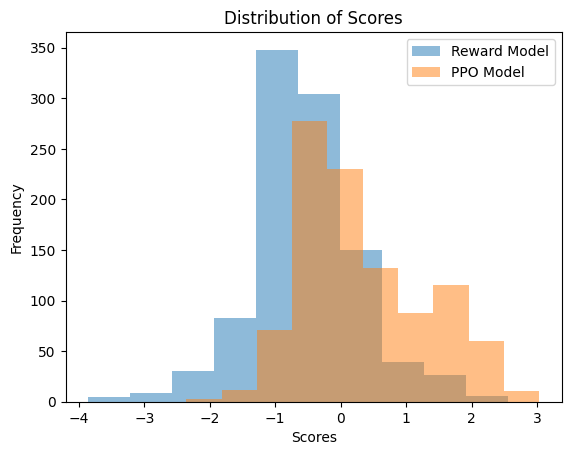

In [21]:
# Create a histogram
plt.hist(reward_scores, alpha=0.5, label='Reward Model')
plt.hist(ppo_scores, alpha=0.5, label='PPO Model')
plt.legend(loc='upper right')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

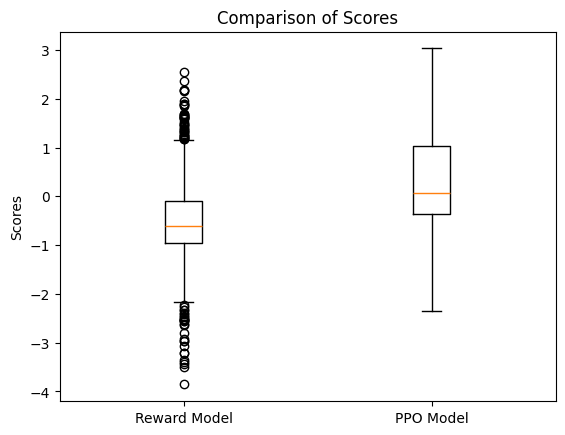

In [25]:
# Create a box plot
ppo_scores = ppo_scores.flatten()
reward_scores = reward_scores.flatten()
plt.boxplot([reward_scores, ppo_scores], labels=['Reward Model', 'PPO Model'])
plt.ylabel('Scores')
plt.title('Comparison of Scores')
plt.show()

### Model Size Evaluation

In [26]:
def get_model_size(model_path):
    """
    Calculates the size of a model on disk.

    Args:
        model_path: The path to the saved model directory.

    Returns:
        The size of the model in MB.
    """
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(model_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 ** 2)  # Convert bytes to MB

# Get the size of the reward model
reward_model_path = "drive/MyDrive/M2 D3S/Math of DL/Project/reward_model"
reward_model_size = get_model_size(reward_model_path)
print(f"Reward Model Size: {reward_model_size:.2f} MB")

# Get the size of the PPO-optimized policy model
ppo_model_path = "drive/MyDrive/M2 D3S/Math of DL/Project/ppo_optimized"
ppo_model_size = get_model_size(ppo_model_path)
print(f"PPO-optimized Policy Model Size: {ppo_model_size:.2f} MB")

Reward Model Size: 479.31 MB
PPO-optimized Policy Model Size: 474.72 MB
